In [1]:
import warnings
warnings.filterwarnings('ignore')
import classyRF_final as classyRF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pathData = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\allEOS\\"
pathClassy = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\"
pathForest = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\SushantForest_2\\"

In [3]:
EOS = ["APR4_EPP", "BHF_BBB2", "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1_PP", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLy", "SLY2", "SLY9", "SLY230A"]
BayesFactor=[1.526, 1.555, 0.056, 1.422, 1.177, 1.283, 0.276, 0.001, 0.009, 0.176, 0.179, 0.159, 0.108, 0.107, 0.33, 0.025, 0.288, 0.29, 0.618, 1.0, 1.028, 0.37, 0.932]
EOSTest = ["APR4_EPP", "BHF_BBB2"]
EOScolor = ['BHF_BBB2', 'SLy', 'MS1B_PP']
color_v = ['orange', 'green', 'blue']

i_m1r=1; i_m2r=2; i_x1r=3; i_x2r=4; i_snr=8;
recovered=[i_m1r, i_m2r, i_x1r, i_x2r, i_snr]


## Load the data and convert to the three categories

In [4]:
EOSdic = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadPickle(pathForest+'random_forest_'+eos)
    RF.load_test_dataset(pathData+eos+'\\EMB\\', 'test_EMB_ID_LABEL_'+eos+'_s300_f0d7.csv')
    aux = RF.labels_test
    RF.load_test_dataset(pathData+eos+'\\NS\\', 'test_NS_ID_LABEL_'+eos+'_s300_f0d7.csv')
    RF.labels_test = RF.labels_test + aux
    RF.subset_test(recovered)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdic[eos] = new_dic
    count = count + 1 

## Bin the probabilities and count events

In [5]:
def get_ntp_nfp(RFdic, ntrees=50):
    ntrees = 50
    predictions=np.zeros(shape=(ntrees,len(RFdic['forest'].labels_test)))
    for i in range(0,ntrees):
        predictions[i] = RFdic['forest'].model.estimators_[i].predict(RFdic['forest'].data_test)
    #label 2
    truelabel =RFdic['forest'].labels_test
    index_events_has = np.where(truelabel == 2)[0]
    index_events_nohas = np.where((truelabel==0) | (truelabel==1))[0]
    c_events_has = predictions[:, index_events_has]
    
    ntreessay2 = np.zeros(len(index_events_has))
    for i in range(0,len(index_events_has)):
        ntreessay2[i] = list(c_events_has[:,i]).count(2)
    ntp, bins = np.histogram(ntreessay2, bins=np.arange(0,52,1))

    c_events_nohas = predictions[:, index_events_nohas]
    ntreessay2 = np.zeros(len(index_events_nohas))
    for i in range(0,len(index_events_nohas)):
        ntreessay2[i] = list(c_events_nohas[:,i]).count(2)
    ntreessay2 = ntrees - ntreessay2
    ntn, bins = np.histogram(ntreessay2, bins=np.arange(0,52,1))
    nfp = ntn[::-1]
    
    RFdic['ntp_2'] = ntp
    RFdic['nfp_2'] = nfp
    RFdic['treesSaySo'] = np.arange(0, 51, 1)/50.0
    RFdic['BayesianProb_2'] = ntp/(ntp+nfp)
    
    #label 1
    truelabel =RFdic['forest'].labels_test
    index_events_has = np.where(truelabel == 1)[0]
    index_events_nohas = np.where((truelabel==0) | (truelabel==2))[0]
    c_events_has = predictions[:, index_events_has]
    
    ntreessay2 = np.zeros(len(index_events_has))
    for i in range(0,len(index_events_has)):
        ntreessay2[i] = list(c_events_has[:,i]).count(1)
    ntp, bins = np.histogram(ntreessay2, bins=np.arange(0,52,1))

    c_events_nohas = predictions[:, index_events_nohas]
    ntreessay2 = np.zeros(len(index_events_nohas))
    for i in range(0,len(index_events_nohas)):
        ntreessay2[i] = list(c_events_nohas[:,i]).count(1)
    ntreessay2 = ntrees - ntreessay2
    ntn, bins = np.histogram(ntreessay2, bins=np.arange(0,52,1))
    nfp = ntn[::-1]
    
    RFdic['ntp_1'] = ntp
    RFdic['nfp_1'] = nfp
    RFdic['BayesianProb_1'] = ntp/(ntp+nfp)    
        
    #label 0
    truelabel =RFdic['forest'].labels_test
    index_events_has = np.where(truelabel == 0)[0]
    index_events_nohas = np.where((truelabel==1) | (truelabel==2))[0]
    c_events_has = predictions[:, index_events_has]
    
    ntreessay2 = np.zeros(len(index_events_has))
    for i in range(0,len(index_events_has)):
        ntreessay2[i] = list(c_events_has[:,i]).count(0)
    ntp, bins = np.histogram(ntreessay2, bins=np.arange(0,52,1))

    c_events_nohas = predictions[:, index_events_nohas]
    ntreessay2 = np.zeros(len(index_events_nohas))
    for i in range(0,len(index_events_nohas)):
        ntreessay2[i] = list(c_events_nohas[:,i]).count(0)
    ntreessay2 = ntrees - ntreessay2
    ntn, bins = np.histogram(ntreessay2, bins=np.arange(0,52,1))
    nfp = ntn[::-1]
    
    RFdic['ntp_0'] = ntp
    RFdic['nfp_0'] = nfp
    RFdic['BayesianProb_0'] = ntp/(ntp+nfp)

In [6]:
from scipy.optimize import curve_fit

def sigmoid_opt1(x, a, b):    #worse for some REM, better for NS
    #domain [0,1], scale if necessary
    return (np.exp(a*b)-np.exp(-a*(x-b)))*(1+np.exp(-a*(1-b)))/((1+np.exp(-a*(x-b)))*(np.exp(a*b)-np.exp(-a*(1-b))))
    
    
def sigmoid_opt2(x, k):   #worse for NS, better for REM
    #domain [0,1], scale if necessary
    return 1/(1+(x/(1-x))**(-k))
    
    
def fit_bayesian(RFdic, only=0): 
    x_scaled = RFdic['treesSaySo']   
    if(only==1 or only==0):
        p0 = [8,0.8]
        #label 2
        popt, pcov = curve_fit(sigmoid_opt1, x_scaled, RFdic['BayesianProb_2'], p0, method = 'lm')
        RFdic['sigmoid1_2'] = popt
        #label 1
        popt, pcov = curve_fit(sigmoid_opt1, x_scaled, RFdic['BayesianProb_1'], p0, method = 'lm')
        RFdic['sigmoid1_1'] = popt
        #label 0
        popt, pcov = curve_fit(sigmoid_opt1, x_scaled, RFdic['BayesianProb_0'], p0, method = 'lm')
        RFdic['sigmoid1_0'] = popt
    if(only==2 or only==0):
        p0 = [0.8]
        #label 2
        popt, pcov = curve_fit(sigmoid_opt2, x_scaled, RFdic['BayesianProb_2'], p0, method = 'lm')
        RFdic['sigmoid2_2'] = popt
        #label 1
        popt, pcov = curve_fit(sigmoid_opt2, x_scaled, RFdic['BayesianProb_1'], p0, method = 'lm')
        RFdic['sigmoid2_1'] = popt
        #label 0
        popt, pcov = curve_fit(sigmoid_opt2, x_scaled, RFdic['BayesianProb_0'], p0, method = 'lm')
        RFdic['sigmoid2_0'] = popt

In [7]:
for eos in EOS:
    get_ntp_nfp(EOSdic[eos])


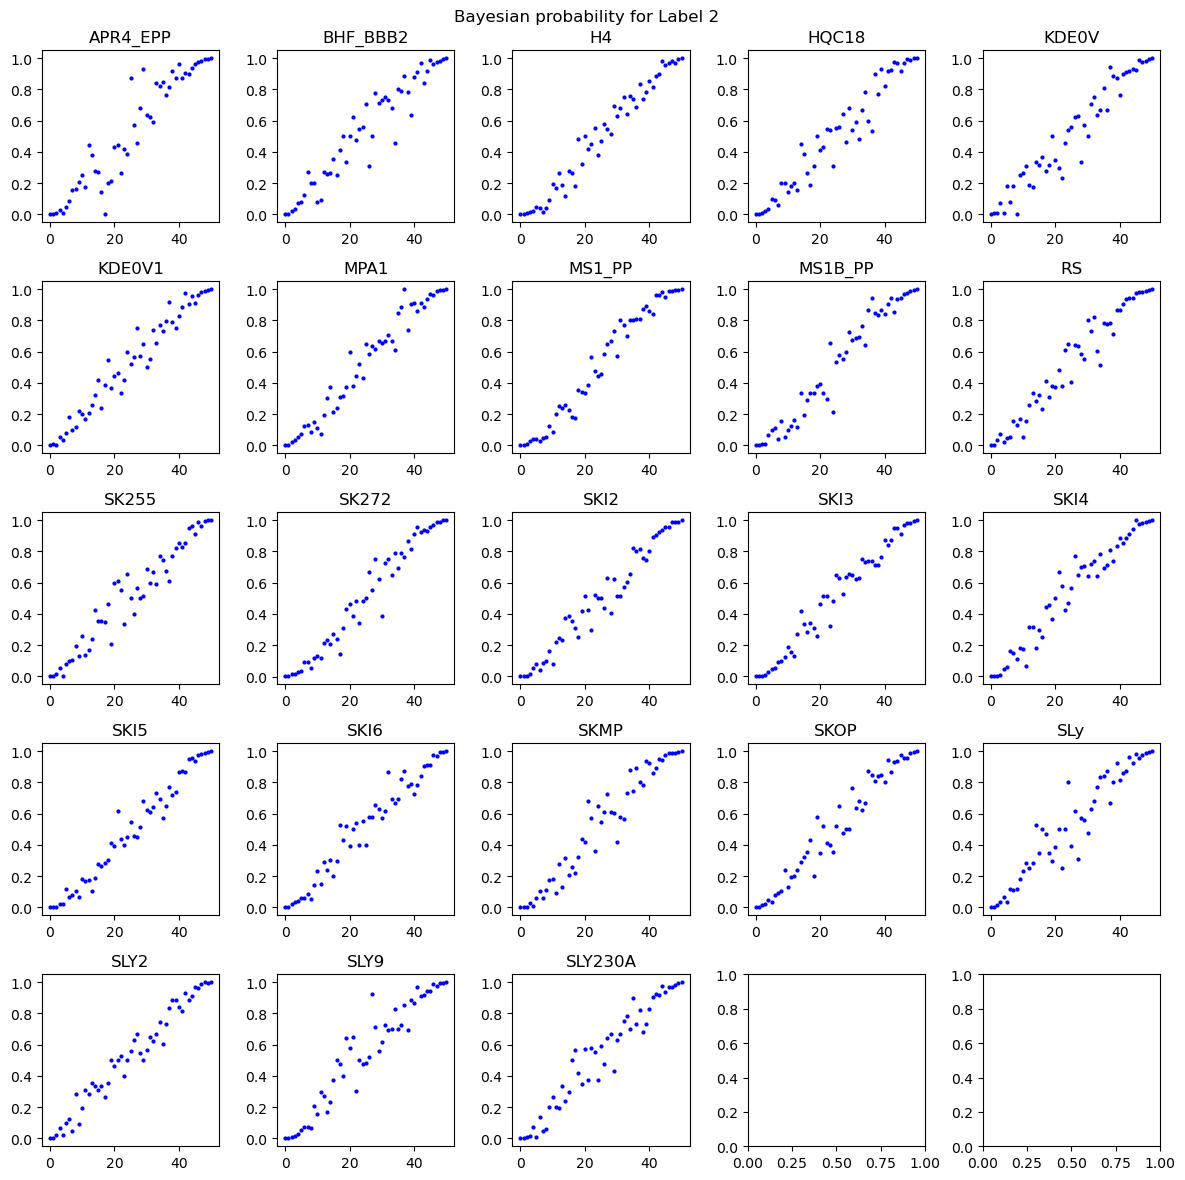

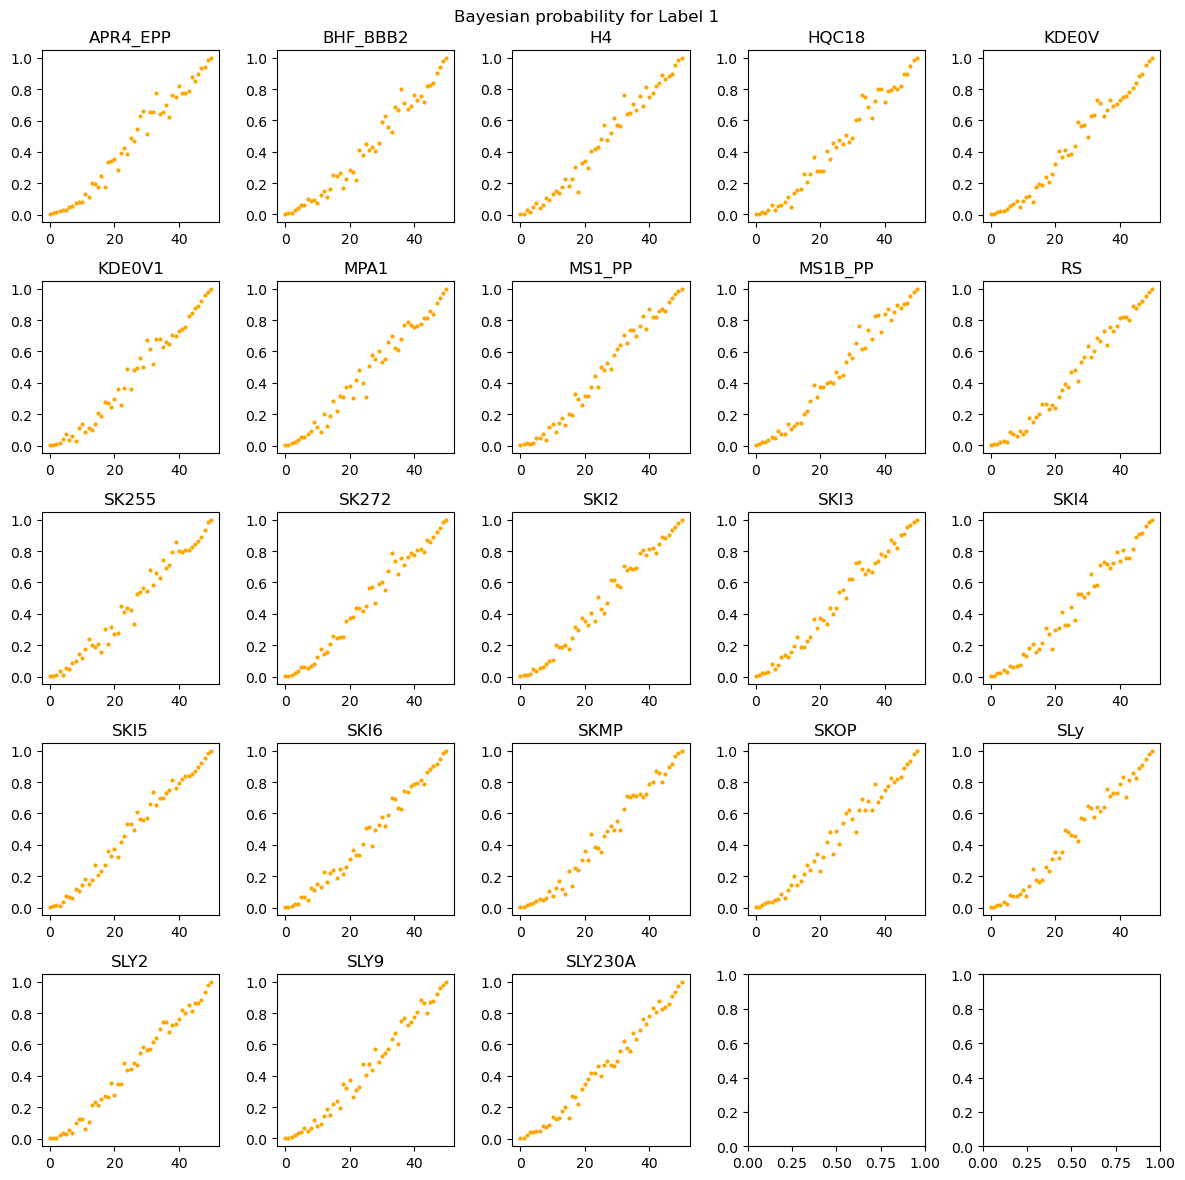

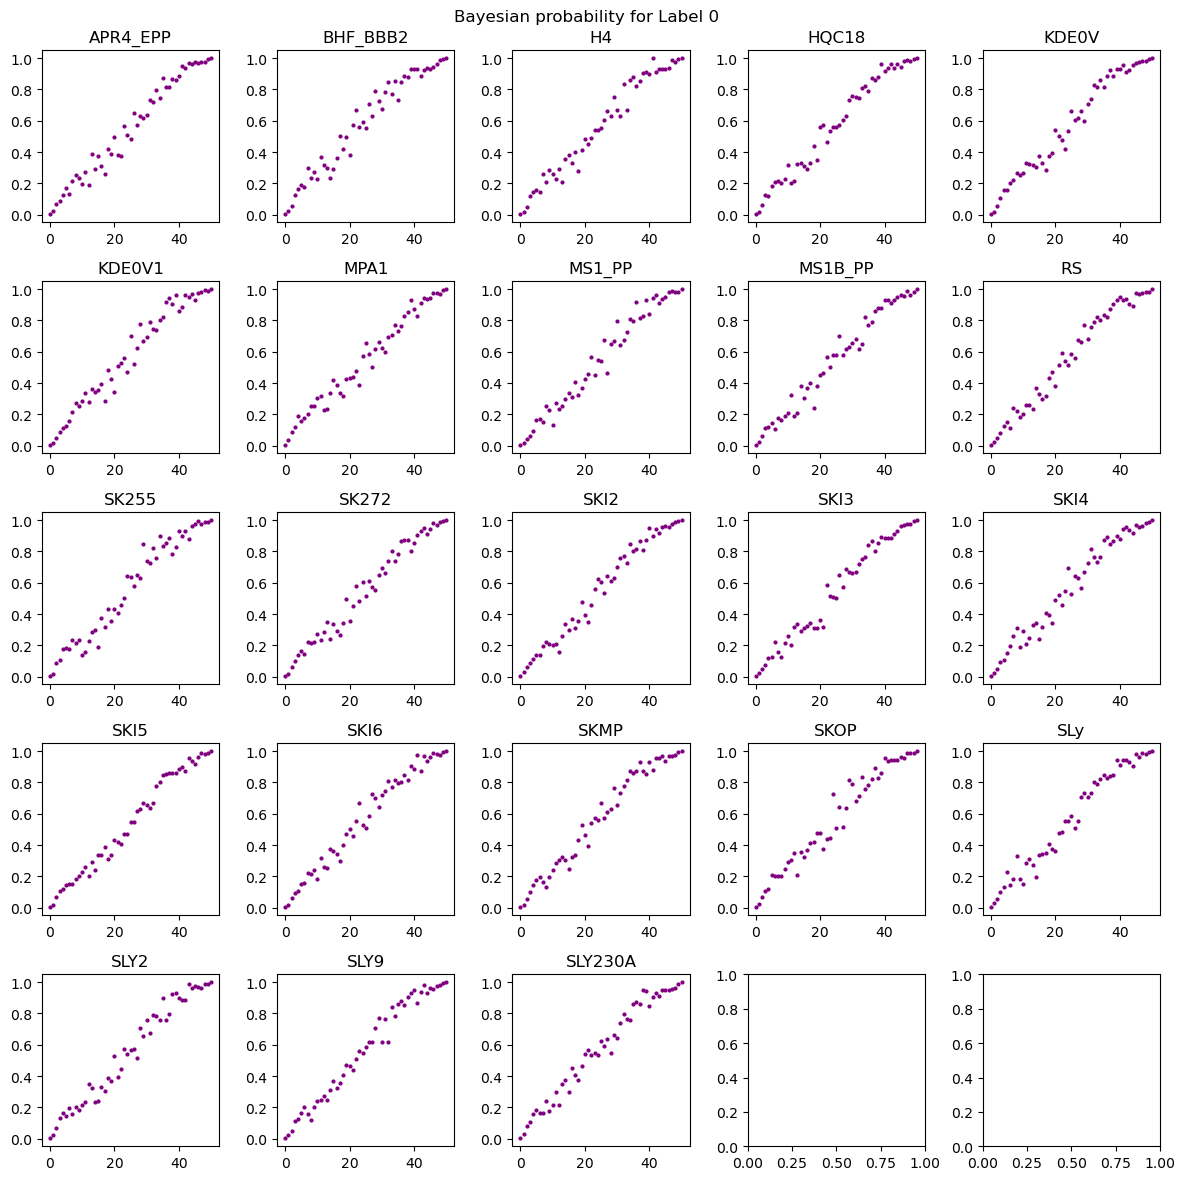

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=4, c='blue')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 2")
fig.tight_layout() 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=4, c='orange')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 1")
fig.tight_layout() 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=4, c='purple')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 0")
fig.tight_layout() 

In [8]:
for eos in EOS:
    fit_bayesian(EOSdic[eos],0)

## Plot results

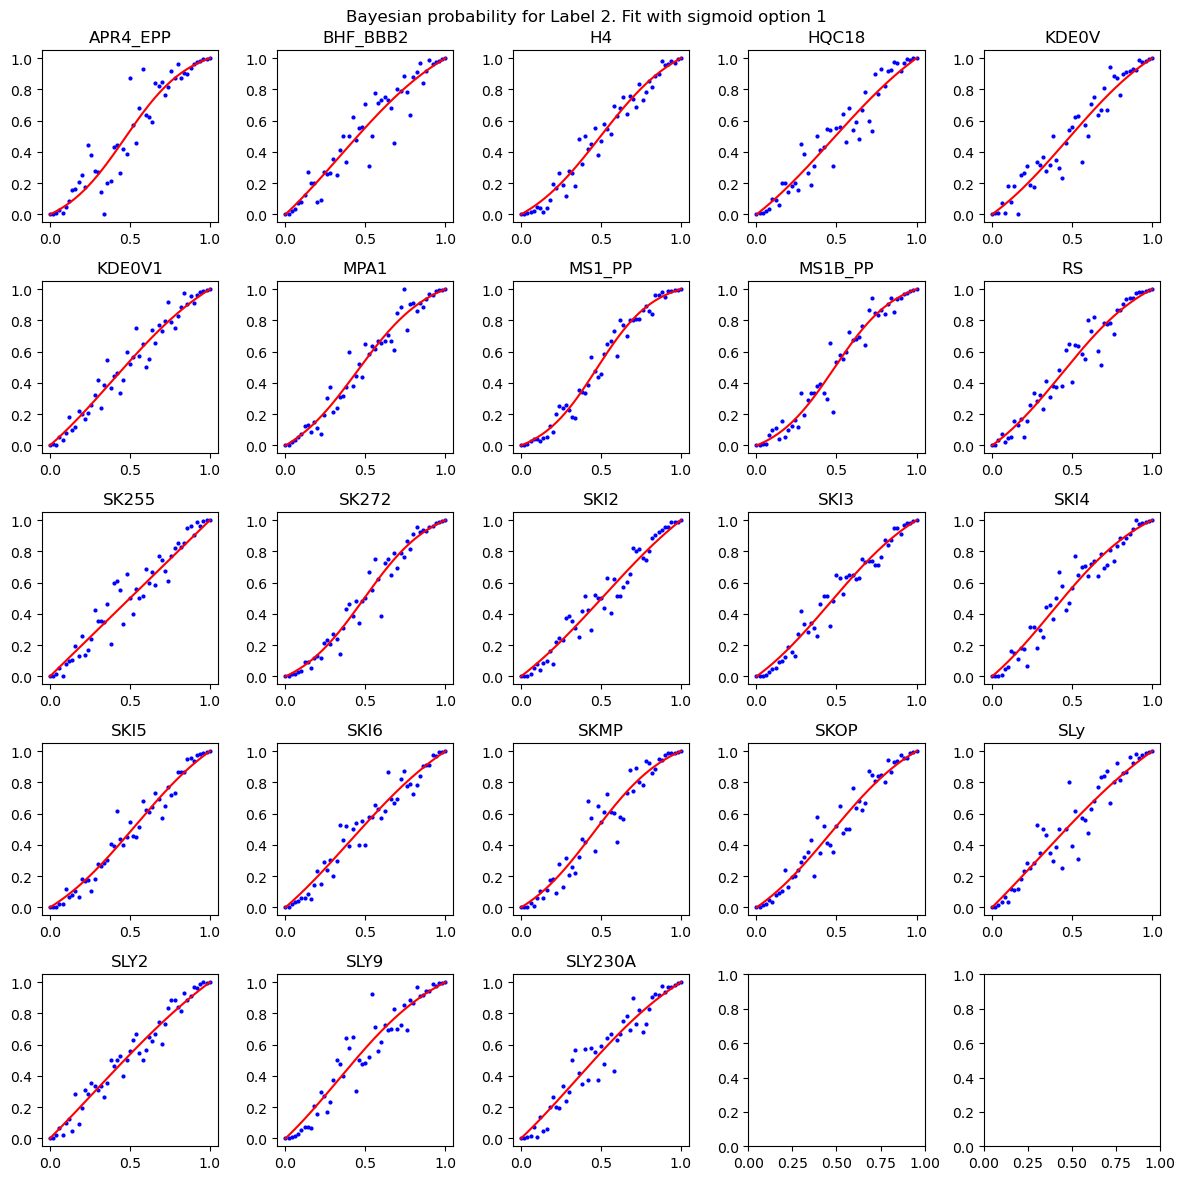

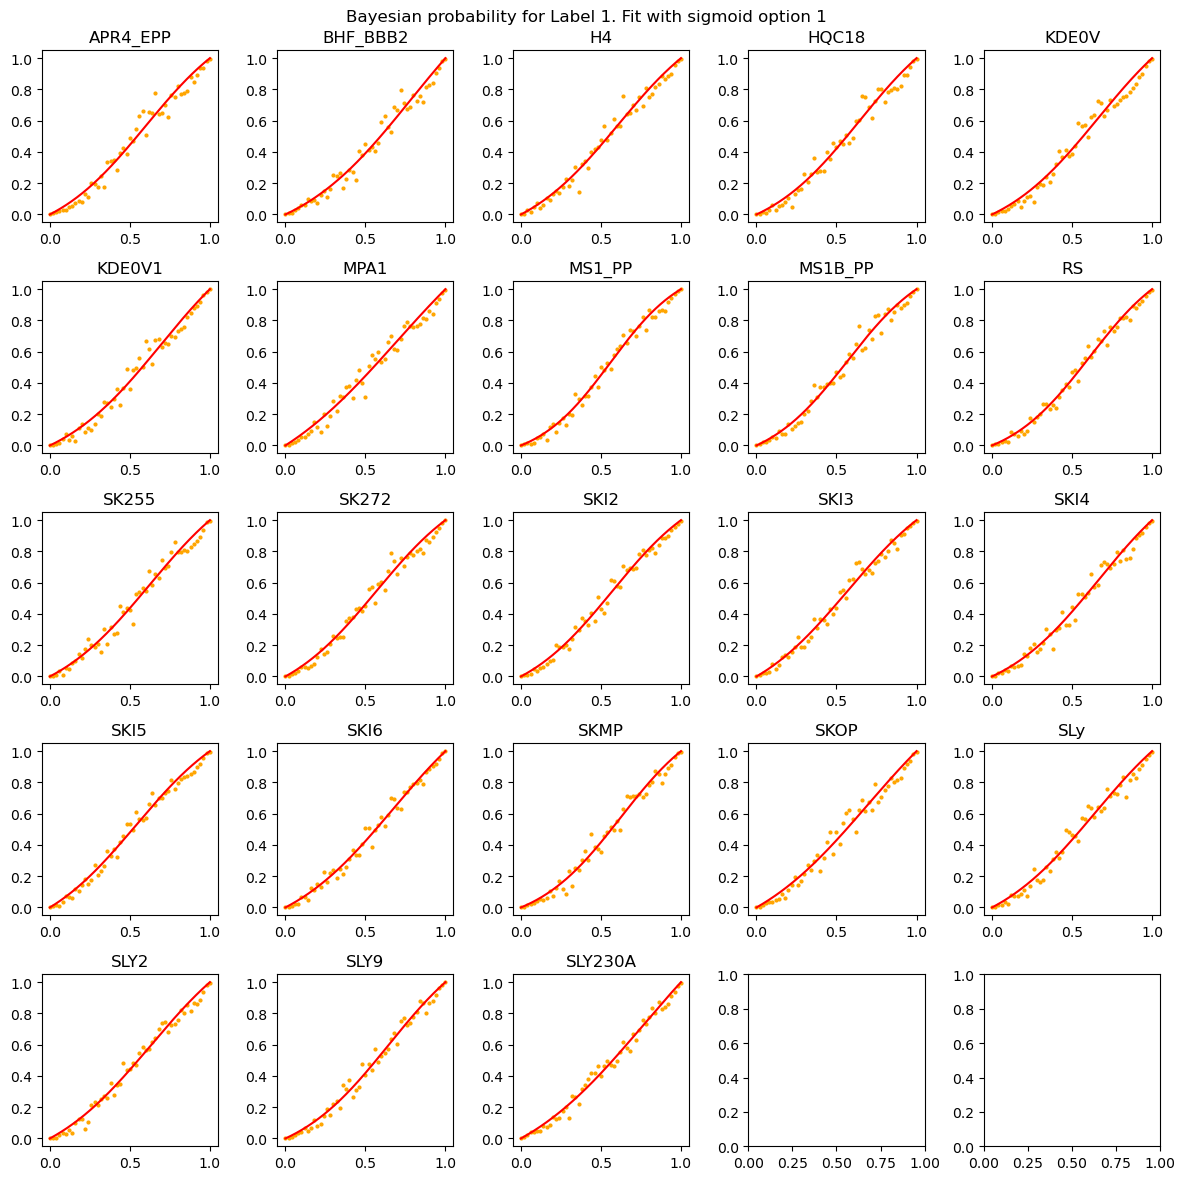

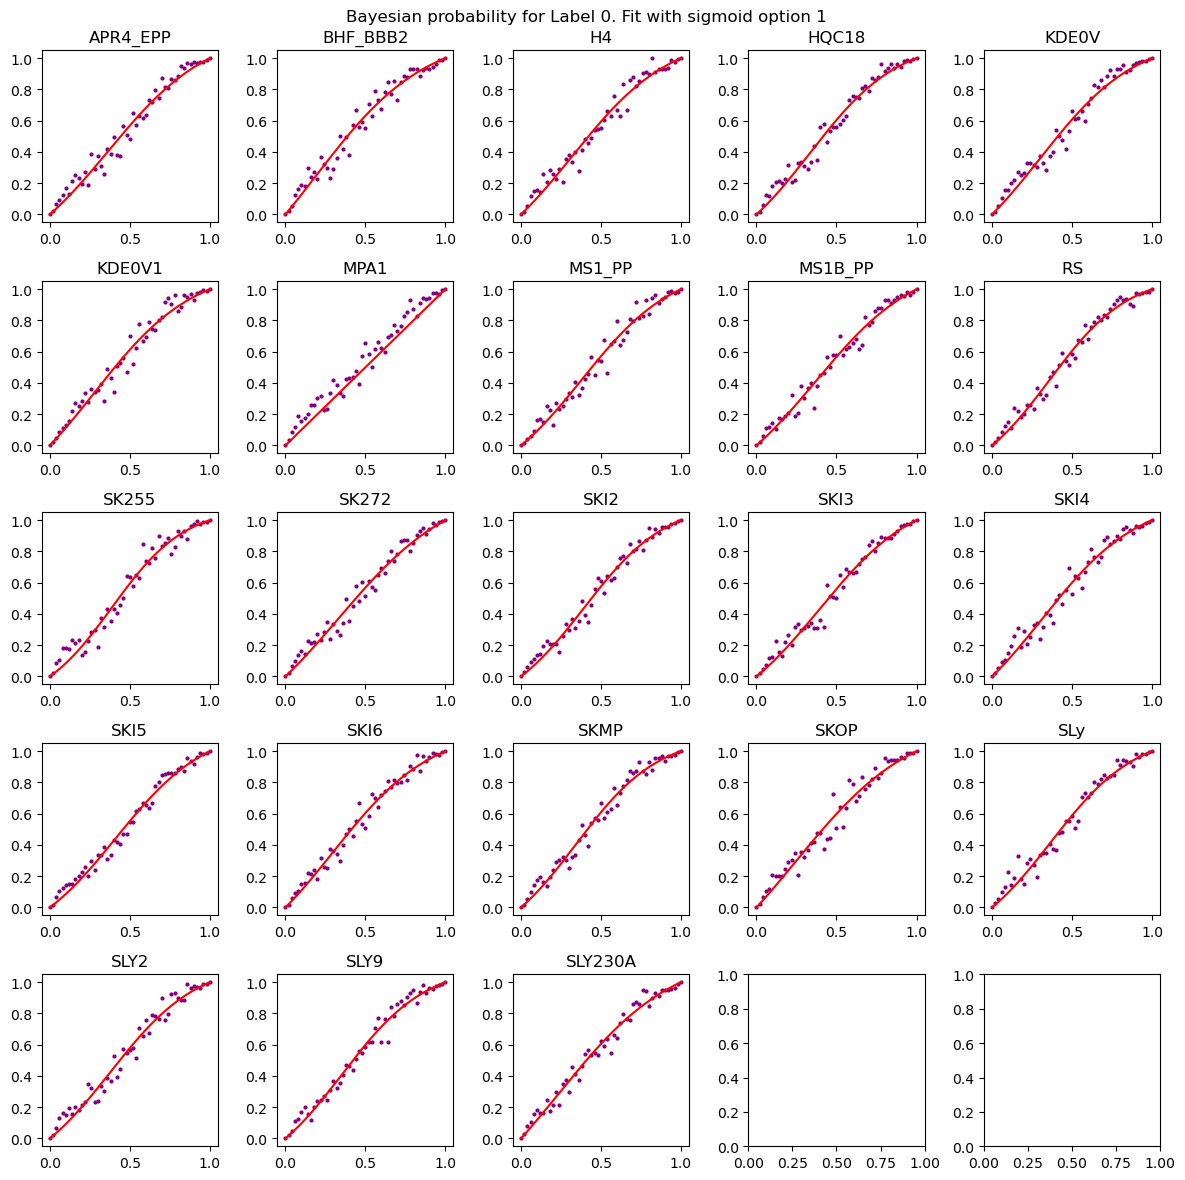

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=4, c='blue')
    axes[i,j].plot(np.linspace(0,1,500), sigmoid_opt1(np.linspace(0,1, 500), *EOSdic[eos]['sigmoid1_2']), c='red')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 2. Fit with sigmoid option 1")
fig.tight_layout() 
plt.show()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=4, c='orange')
    axes[i,j].plot(np.linspace(0,1,500), sigmoid_opt1(np.linspace(0,1, 500), *EOSdic[eos]['sigmoid1_1']), c='red')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 1. Fit with sigmoid option 1")
fig.tight_layout() 
plt.show()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=4,c='purple')
    axes[i,j].plot(np.linspace(0,1,500), sigmoid_opt1(np.linspace(0,1, 500), *EOSdic[eos]['sigmoid1_0']), c='red')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 0. Fit with sigmoid option 1")
fig.tight_layout() 
plt.show()

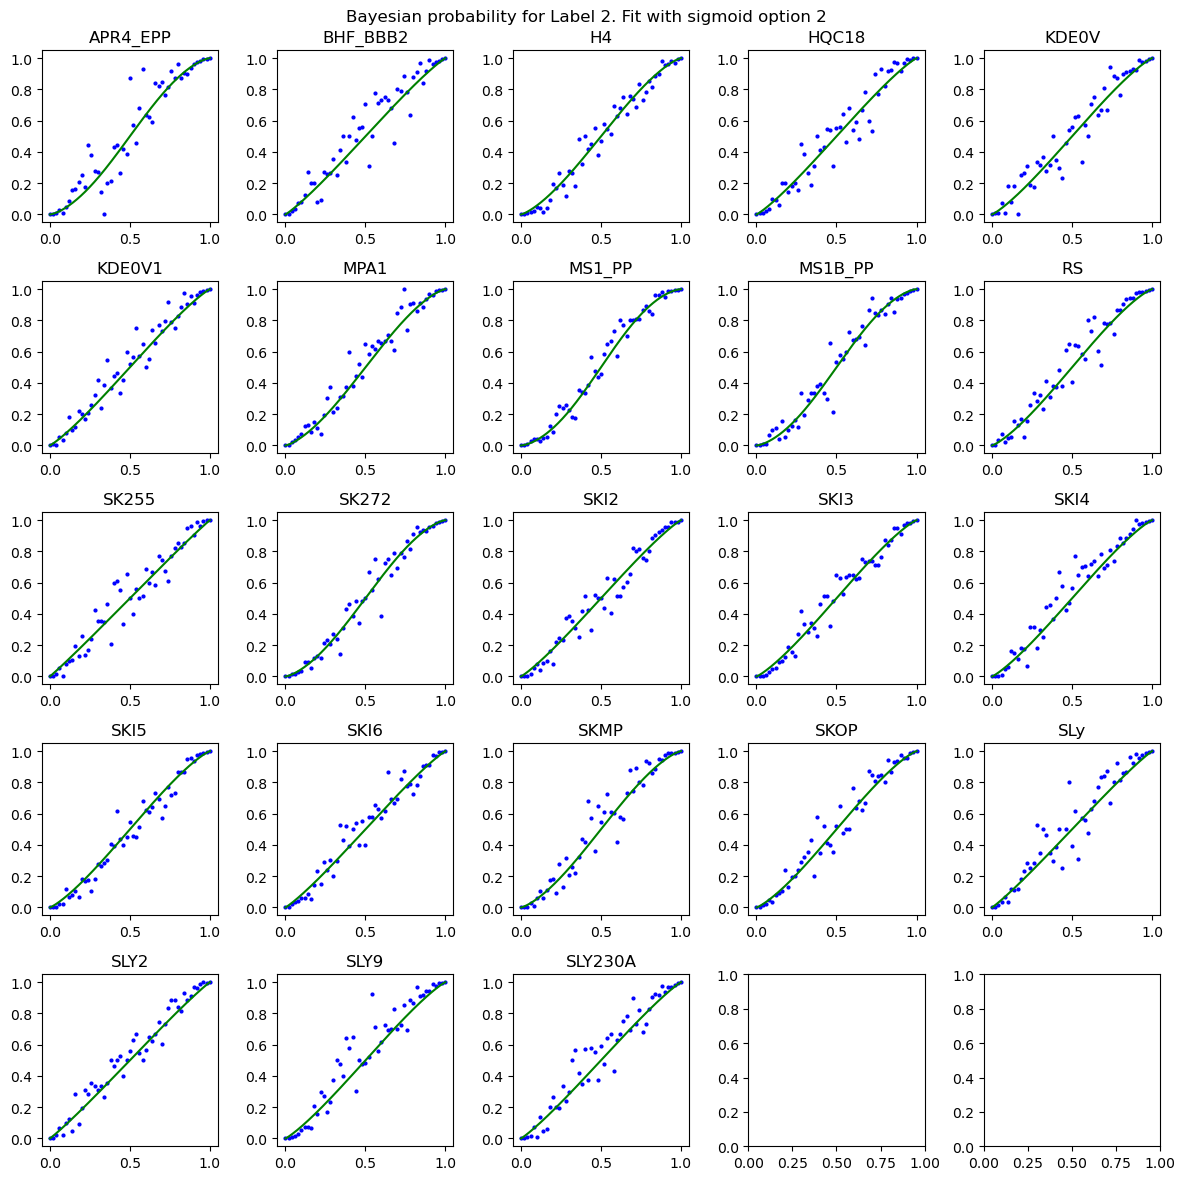

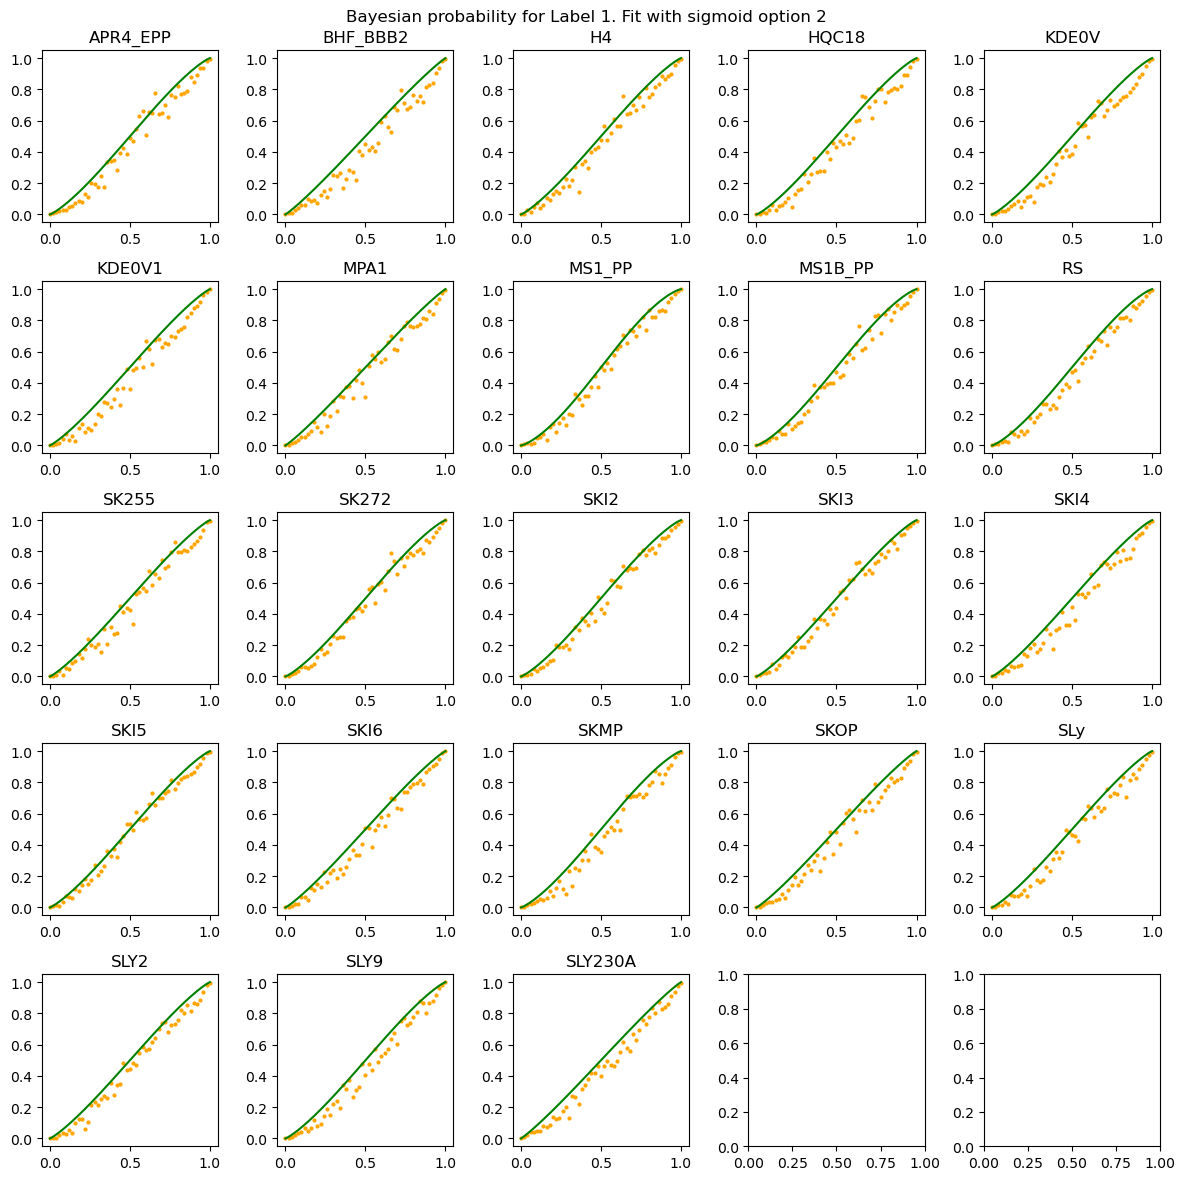

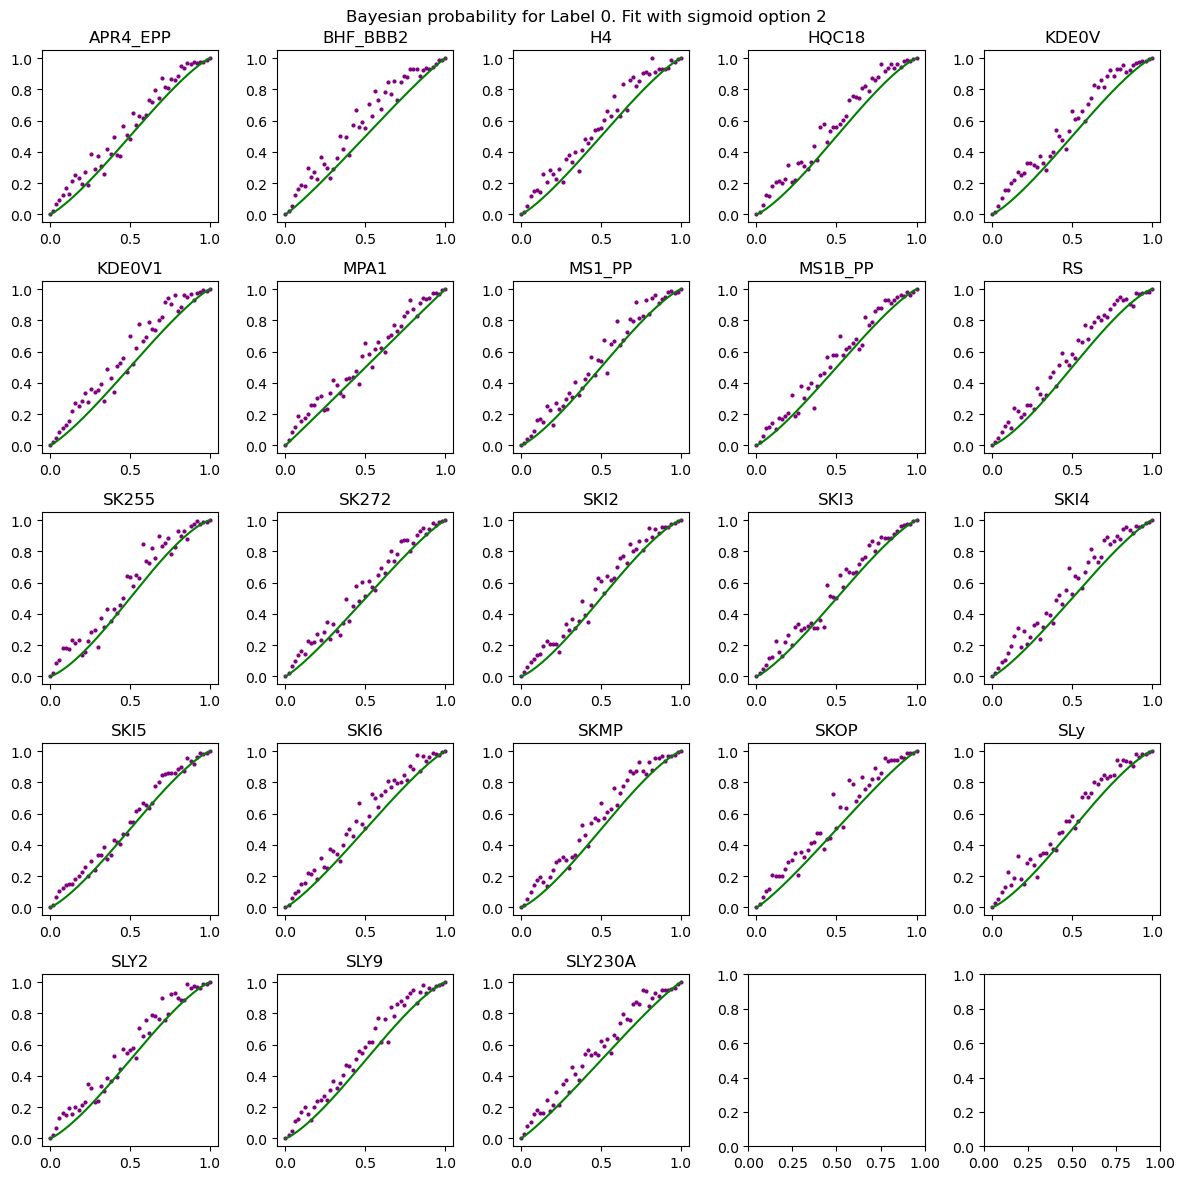

In [39]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=4, c='blue')
    axes[i,j].plot(np.linspace(0,1,500), sigmoid_opt2(np.linspace(0,1, 500), EOSdic[eos]['sigmoid2_2']), c='green')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 2. Fit with sigmoid option 2")
fig.tight_layout() 
plt.show()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=4, c='orange')
    axes[i,j].plot(np.linspace(0,1,500), sigmoid_opt2(np.linspace(0,1, 500), EOSdic[eos]['sigmoid2_1']), c='green')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 1. Fit with sigmoid option 2")
fig.tight_layout() 
plt.show()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=4,c='purple')
    axes[i,j].plot(np.linspace(0,1,500), sigmoid_opt2(np.linspace(0,1, 500), EOSdic[eos]['sigmoid2_0']), c='green')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for Label 0. Fit with sigmoid option 2")
fig.tight_layout() 
plt.show()

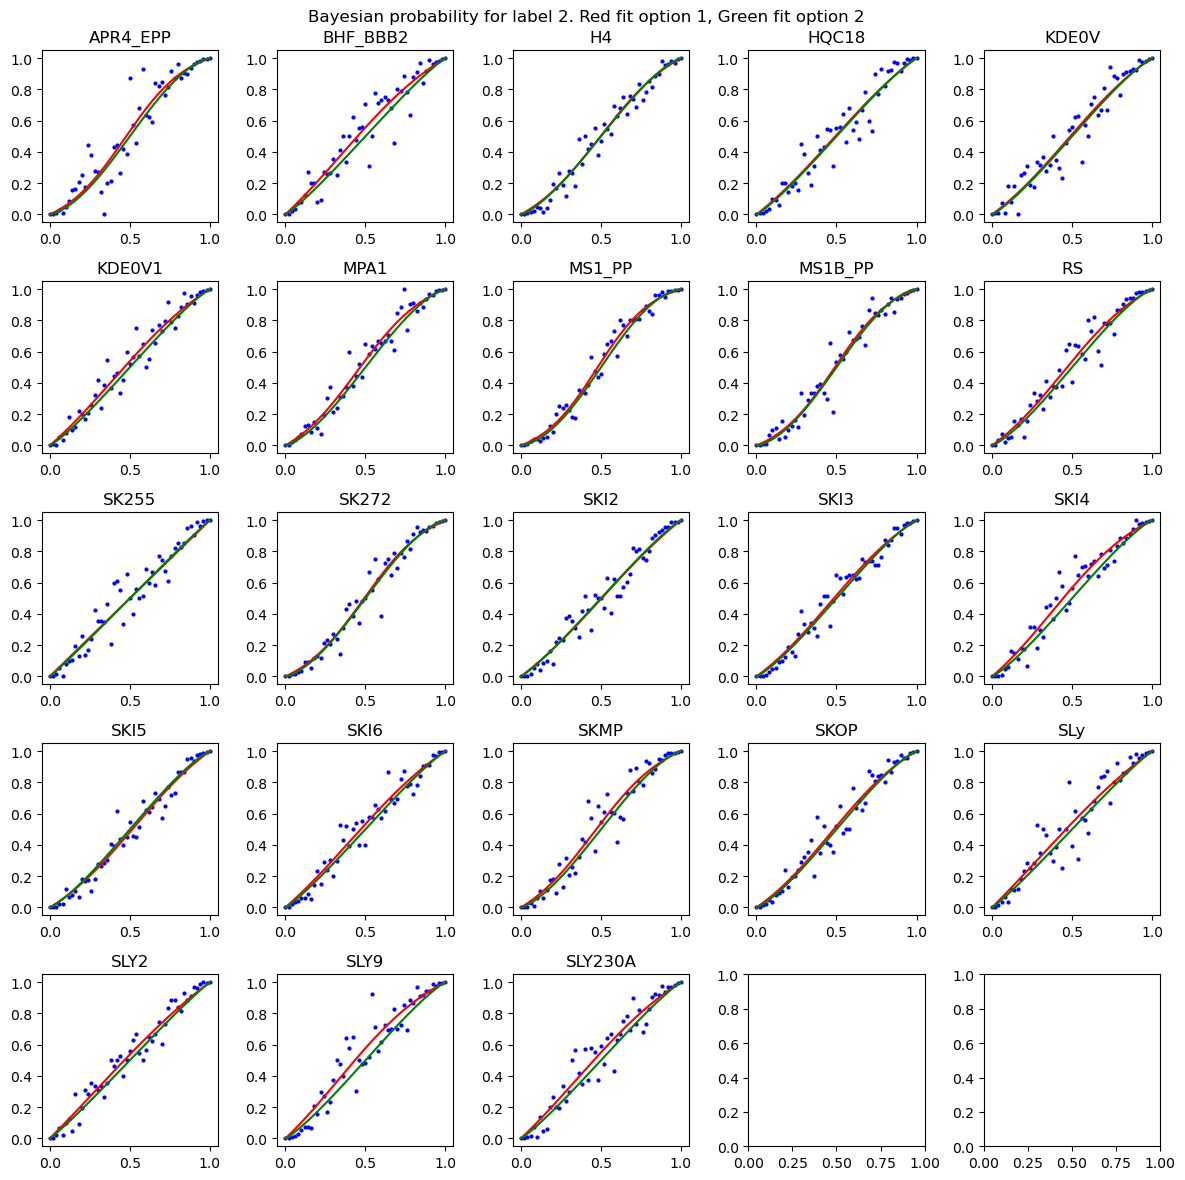

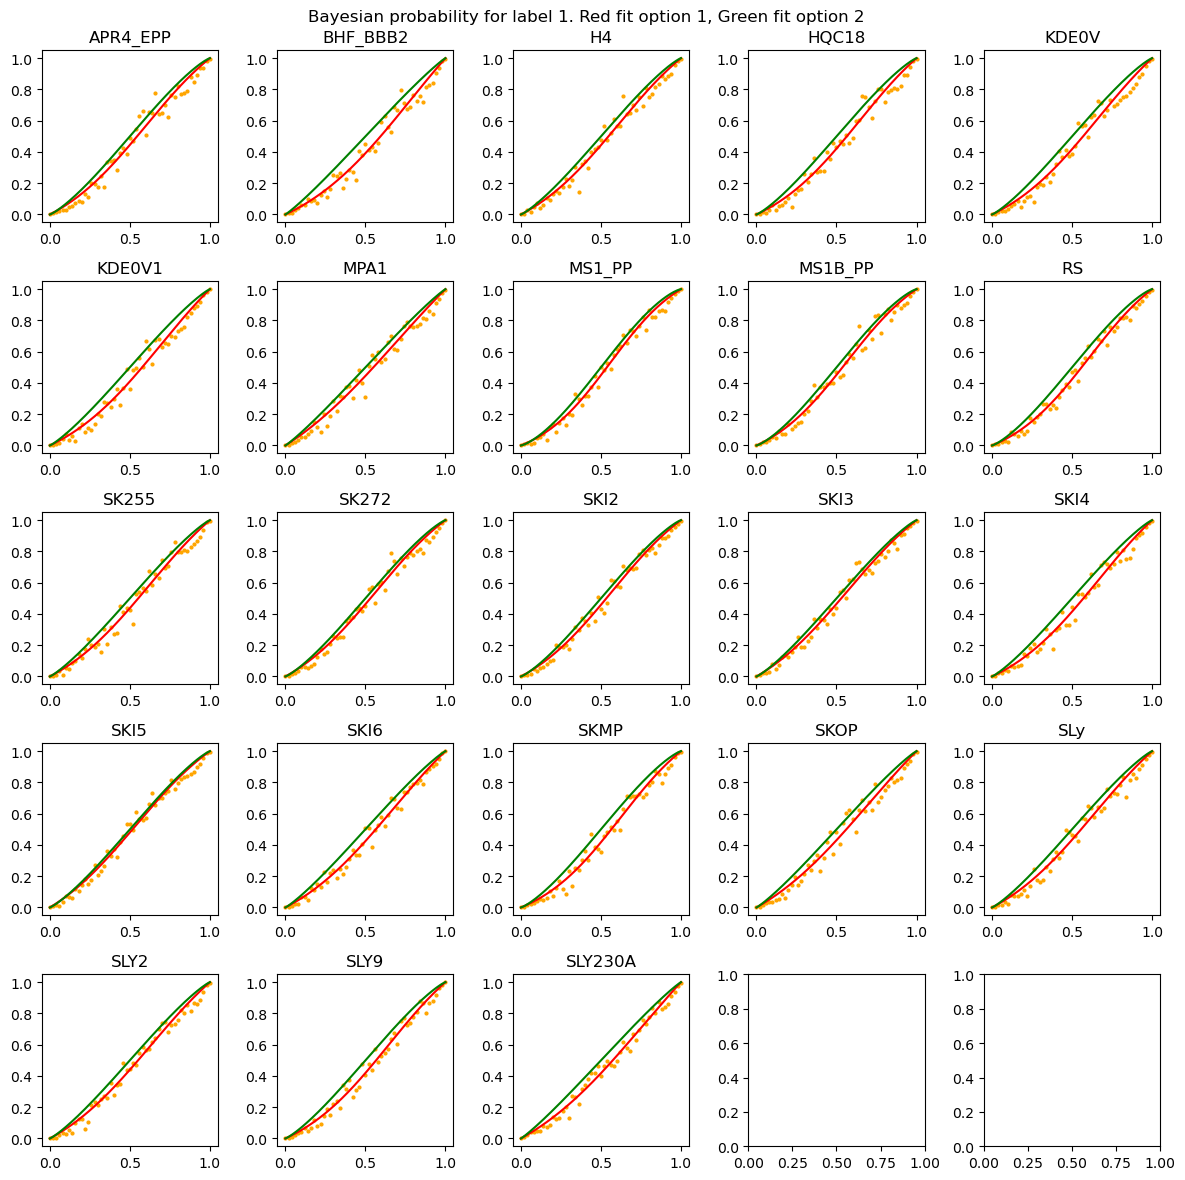

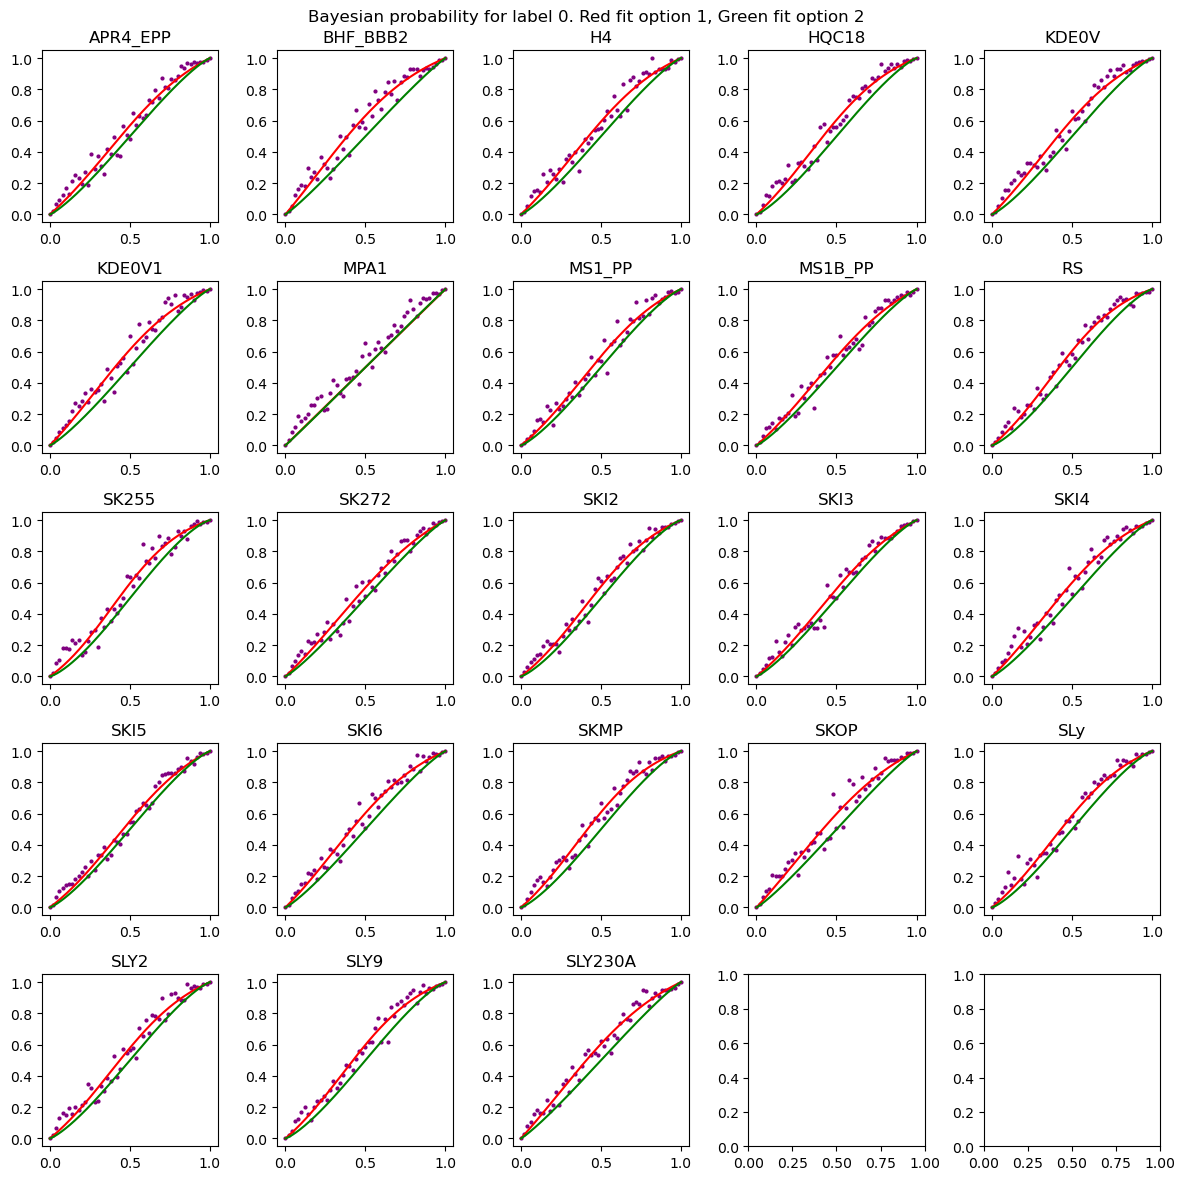

In [40]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=4,c='blue')
    axes[i,j].plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1, 200), *EOSdic[eos]['sigmoid1_2']), c='red')
    axes[i,j].plot(np.linspace(0,1,200), sigmoid_opt2(np.linspace(0,1, 200), *EOSdic[eos]['sigmoid2_2']), c='green')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for label 2. Red fit option 1, Green fit option 2")
fig.tight_layout() 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=4,c='orange')
    axes[i,j].plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1, 200), *EOSdic[eos]['sigmoid1_1']), c='red')
    axes[i,j].plot(np.linspace(0,1,200), sigmoid_opt2(np.linspace(0,1, 200), *EOSdic[eos]['sigmoid2_1']), c='green')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for label 1. Red fit option 1, Green fit option 2")
fig.tight_layout() 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12,12))
i = 0; j = 0;
for eos in EOS:
    axes[i,j].scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=4,c='purple')
    axes[i,j].plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1, 200), *EOSdic[eos]['sigmoid1_0']), c='red')
    axes[i,j].plot(np.linspace(0,1,200), sigmoid_opt2(np.linspace(0,1, 200), *EOSdic[eos]['sigmoid2_0']), c='green')
    axes[i,j].set_title(eos)
    j = j + 1
    if (j > 4):
        j=0
        i=i+1
_=fig.suptitle("Bayesian probability for label 0. Red fit option 1, Green fit option 2")
fig.tight_layout() 

The red line, fit with sigmoid_op1, is better. We could print the residual of the fit to say so quantitatively

## Plots that we could put in the paper

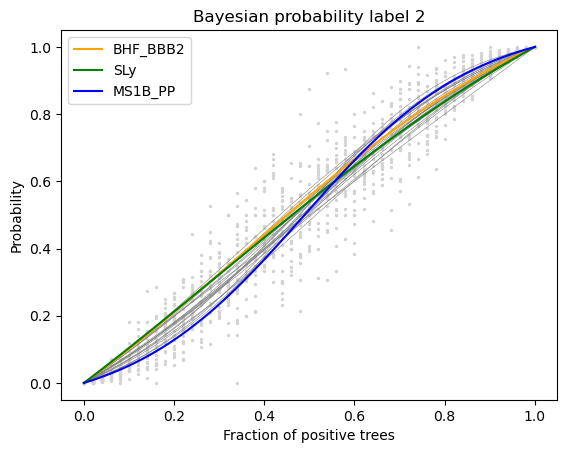

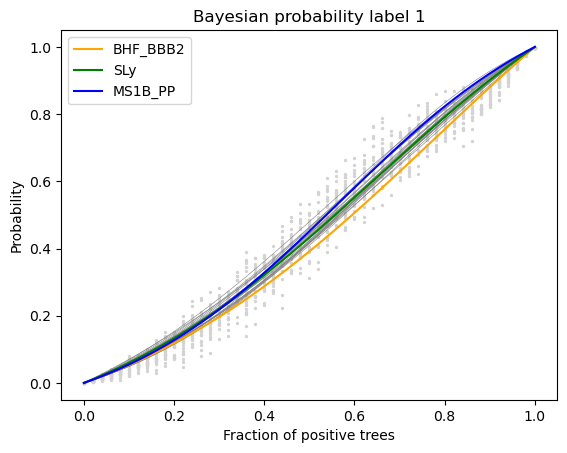

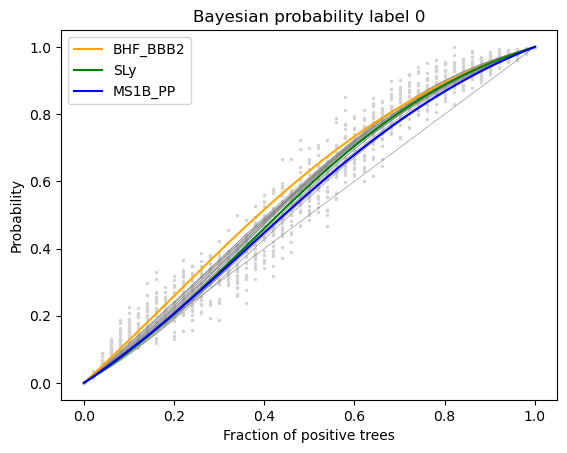

In [43]:
color_count = 0;
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_2']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_2']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.legend()
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Bayesian probability label 2')
plt.show()

color_count = 0;
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_1']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_1']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.legend()
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Bayesian probability label 1')
plt.show()

color_count = 0;
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_0']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_0']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.legend()
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Bayesian probability label 0')
plt.show()

## Weighted average

I can think of two alternatives: 
- we do the weighted average of the bayesian probabilities for each EoS, then do a single fit
- we have a fit for every EoS, and to obtain the probability for a given number of trees we do the weighted average of the output of each fit

----> We can jump to the end, because they prove to be the same for NS, and very similar for REM

In [9]:
def r2_op1(xdata, ydata, popt):
    residuals = ydata- sigmoid_opt1(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared
def r2_op2(xdata, ydata, popt):
    residuals = ydata- sigmoid_opt2(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

### Idea 1: weighted average of probabilities, a single fit

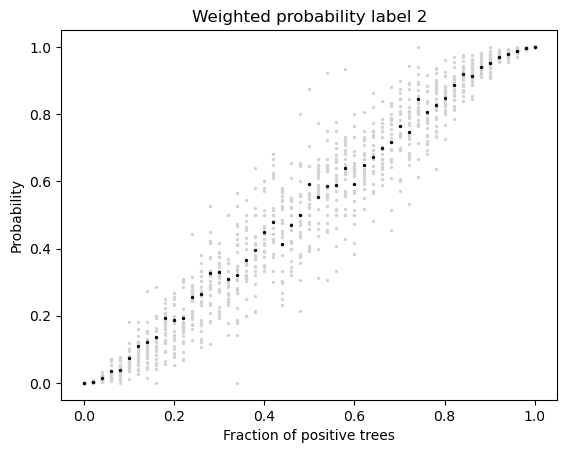

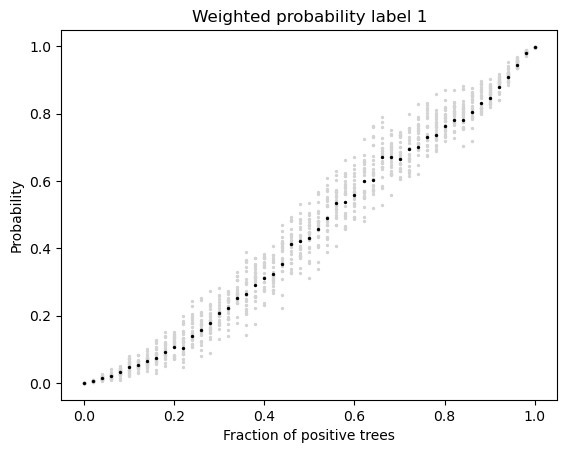

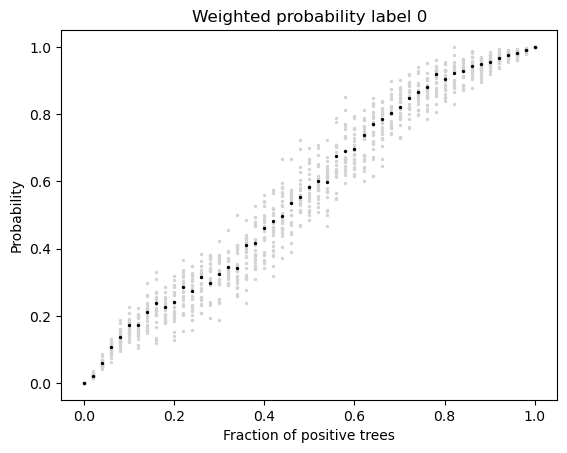

In [11]:
prob_2 = np.zeros(len(EOSdic['SLy']['BayesianProb_2']))
for eos in EOS:
    prob_2 = prob_2 + EOSdic[eos]['BayesianProb_2']*EOSdic[eos]['weight']
prob_2 = prob_2/sum(BayesFactor)

prob_1 = np.zeros(len(EOSdic['SLy']['BayesianProb_1']))
for eos in EOS:
    prob_1 = prob_1 + EOSdic[eos]['BayesianProb_1']*EOSdic[eos]['weight']
prob_1 = prob_1/sum(BayesFactor)

prob_0 = np.zeros(len(EOSdic['SLy']['BayesianProb_0']))
for eos in EOS:
    prob_0 = prob_0 + EOSdic[eos]['BayesianProb_0']*EOSdic[eos]['weight']
prob_0 = prob_0/sum(BayesFactor)

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=2, c='lightgray')
plt.scatter(EOSdic['SLy']['treesSaySo'], prob_2, s=2, c='black')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Weighted probability label 2')
plt.show()

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=2, c='lightgray')
plt.scatter(EOSdic['SLy']['treesSaySo'], prob_1, s=2, c='black')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Weighted probability label 1')
plt.show()

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=2, c='lightgray')
plt.scatter(EOSdic['SLy']['treesSaySo'], prob_0, s=2, c='black')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Weighted probability label 0')
plt.show()

-----LABEL 2-----
Option 1 has residual  0.9892281468027314
Option 2 has residual  0.9888271532185825


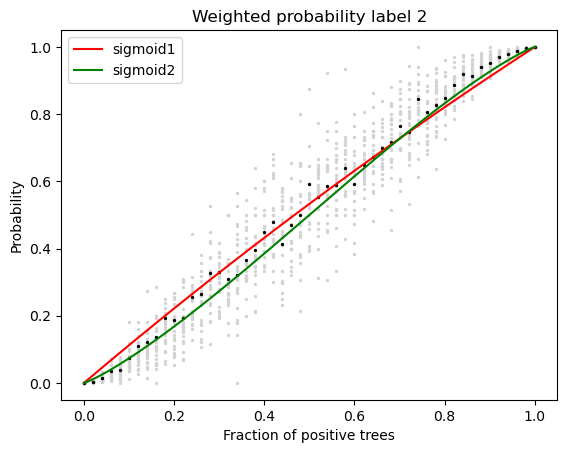

-----LABEL 1-----
Option 1 has residual  0.9938883805286536
Option 2 has residual  0.9640827402726656


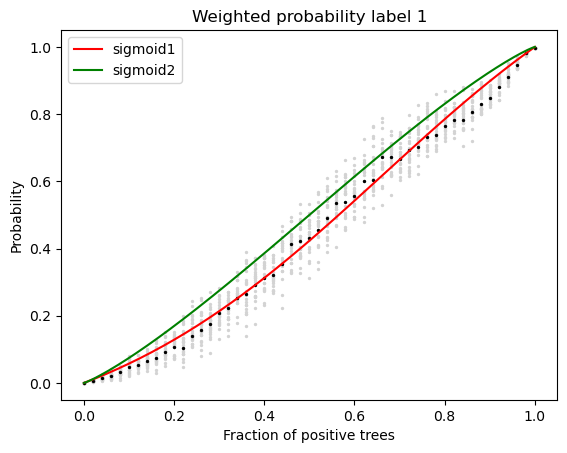

-----LABEL 0-----
Option 1 has residual  0.9854014034303359
Option 2 has residual  0.9425494871816839


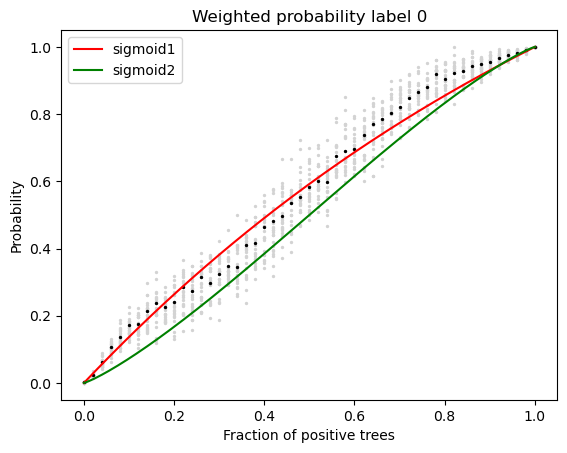

In [13]:
print("-----LABEL 2-----")
p0 = [0.8, 8]
popt, pcov = curve_fit(sigmoid_opt1, np.linspace(0,1,51), prob_2, p0, method = 'lm')
a_2, b_2 = popt
print("Option 1 has residual ", r2_op1(np.linspace(0,1,51), prob_2, popt))
    
p0 = [0.8]
popt, pcov = curve_fit(sigmoid_opt2, np.linspace(0,1,51), prob_2, p0, method = 'lm')
k_REM = popt
print("Option 2 has residual ", r2_op2(np.linspace(0,1,51), prob_2, popt))

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=2, c='lightgray')
plt.scatter(EOSdic['SLy']['treesSaySo'], prob_2, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_2, b_2), c='red', label='sigmoid1')
plt.plot(np.linspace(0,1,200), sigmoid_opt2(np.linspace(0,1,200), k_REM), c='green', label='sigmoid2')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Weighted probability label 2')
plt.legend()
plt.show()

print("-----LABEL 1-----")
p0 = [0.8, 8]
popt, pcov = curve_fit(sigmoid_opt1, np.linspace(0,1,51), prob_1, p0, method = 'lm')
a_1, b_1 = popt
print("Option 1 has residual ", r2_op1(np.linspace(0,1,51), prob_1, popt))
    
p0 = [0.8]
popt, pcov = curve_fit(sigmoid_opt2, np.linspace(0,1,51), prob_1, p0, method = 'lm')
k_REM = popt
print("Option 2 has residual ", r2_op2(np.linspace(0,1,51), prob_1, popt))

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1'], s=2, c='lightgray')
plt.scatter(EOSdic['SLy']['treesSaySo'], prob_1, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_1, b_1), c='red', label='sigmoid1')
plt.plot(np.linspace(0,1,200), sigmoid_opt2(np.linspace(0,1,200), k_REM), c='green', label='sigmoid2')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Weighted probability label 1')
plt.legend()
plt.show()

print("-----LABEL 0-----")
p0 = [0.8, 8]
popt, pcov = curve_fit(sigmoid_opt1, np.linspace(0,1,51), prob_0, p0, method = 'lm')
a_0, b_0 = popt
print("Option 1 has residual ", r2_op1(np.linspace(0,1,51), prob_0, popt))
    
p0 = [0.8]
popt, pcov = curve_fit(sigmoid_opt2, np.linspace(0,1,51), prob_0, p0, method = 'lm')
k_REM = popt
print("Option 2 has residual ", r2_op2(np.linspace(0,1,51), prob_0, popt))

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_0'], s=2, c='lightgray')
plt.scatter(EOSdic['SLy']['treesSaySo'], prob_0, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_0, b_0), c='red', label='sigmoid1')
plt.plot(np.linspace(0,1,200), sigmoid_opt2(np.linspace(0,1,200), k_REM), c='green', label='sigmoid2')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Weighted probability label 0')
plt.legend()
plt.show()

Again option 1 for the fit is better

### Idea 2: weighted average of fit results

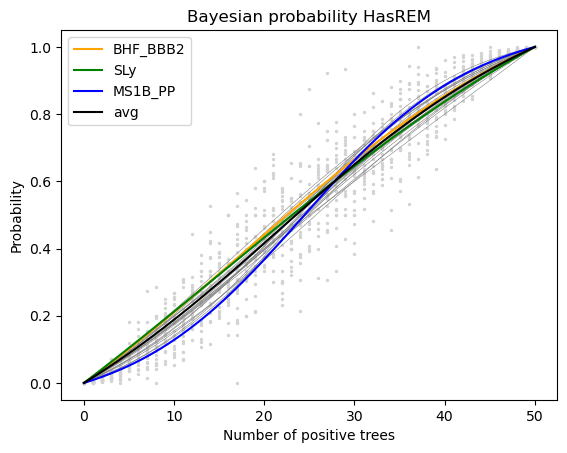

In [72]:
x_points = np.linspace(0,1,200)
prob_wa_REM = np.zeros(200)
for eos in EOS:
    prob_wa_REM = prob_wa_REM + sigmoid_opt1(x_points, *EOSdic[eos]['sigmoid1_REM'])*EOSdic[eos]['weight']
prob_wa_REM = prob_wa_REM/sum(BayesFactor)

color_count = 0;
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_REM'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,50,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_REM']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,50,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_REM']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.plot(np.linspace(0,50,200), prob_wa_REM, c='black',label = 'avg')
plt.legend()
plt.xlabel('Number of positive trees')
plt.ylabel('Probability')
plt.title('Bayesian probability HasREM')
plt.show()

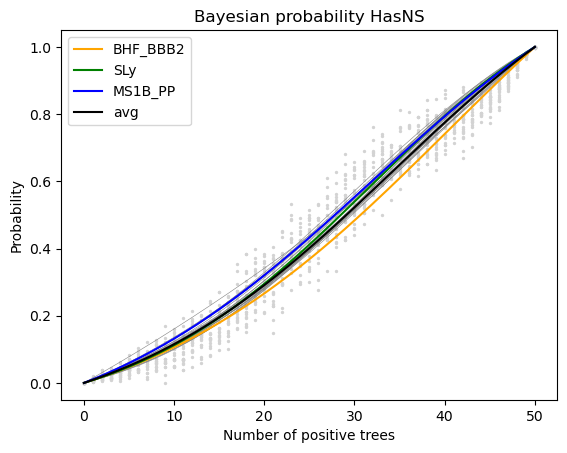

In [70]:
x_points = np.linspace(0,1,200)
prob_wa_NS = np.zeros(200)
for eos in EOS:
    prob_wa_NS = prob_wa_NS + sigmoid_opt1(x_points, *EOSdic[eos]['sigmoid1_NS'])*EOSdic[eos]['weight']
prob_wa_NS = prob_wa_NS/sum(BayesFactor)

color_count = 0;
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_NS'], s=2, c='lightgray')
    if( eos not in EOScolor): 
        plt.plot(np.linspace(0,50,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_NS']), c='grey', lw=0.4)
for eos in EOScolor:
    plt.plot(np.linspace(0,50,200), sigmoid_opt1(np.linspace(0,1,200), *EOSdic[eos]['sigmoid1_NS']), c=color_v[color_count], label=eos)
    color_count = color_count + 1
plt.plot(np.linspace(0,50,200), prob_wa_NS, c='black',label = 'avg')
plt.legend()
plt.xlabel('Number of positive trees')
plt.ylabel('Probability')
plt.title('Bayesian probability HasNS')
plt.show()

### Comparison

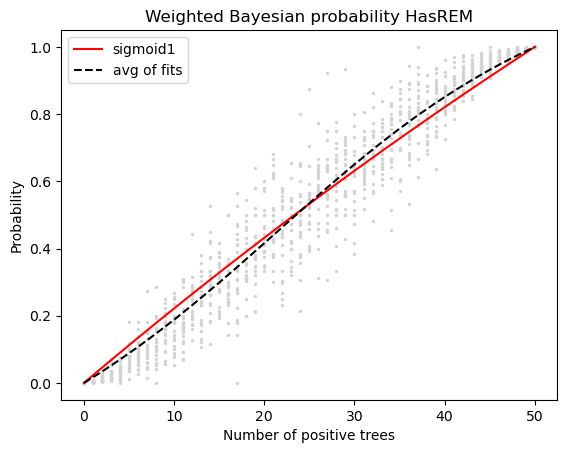

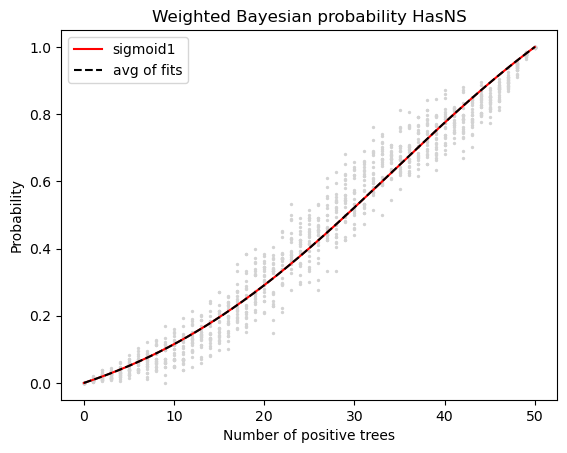

In [76]:
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_REM'], s=2, c='lightgray')
plt.plot(np.linspace(0,50,200), sigmoid_opt1(np.linspace(0,1,200), a_REM, b_REM), c='red', label='sigmoid1')
plt.plot(np.linspace(0,50,200), prob_wa_REM, '--',c='black',label = 'avg of fits')
plt.legend()
plt.xlabel('Number of positive trees')
plt.ylabel('Probability')
plt.title('Weighted Bayesian probability HasREM')
plt.show()

for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_NS'], s=2, c='lightgray')
plt.plot(np.linspace(0,50,200), sigmoid_opt1(np.linspace(0,1,200), a_NS, b_NS), c='red', label='sigmoid1')
plt.plot(np.linspace(0,50,200), prob_wa_NS, '--',c='black',label = 'avg of fits')
plt.legend()
plt.xlabel('Number of positive trees')
plt.ylabel('Probability')
plt.title('Weighted Bayesian probability HasNS')
plt.show()

Therefore, we should do the weighted average of the bayesian probabilities and then do a single fit

In [77]:
params_REMfit = [a_REM, b_REM]
params_NSfit = [a_NS, b_NS]

## Probability inversion with fits?

We have to check that P(HasNS) > P(HasREM)

But they are Bayesian probabilities. It is 

    P(HasNS for real | nns trees say HasNS)

    P(HasREM for real | nrem trees say HasREM) 
    
We cannot have the same x axis. Also nns>nrem always, as nrem=n2 (trees say category 2), and nns=n1+n2

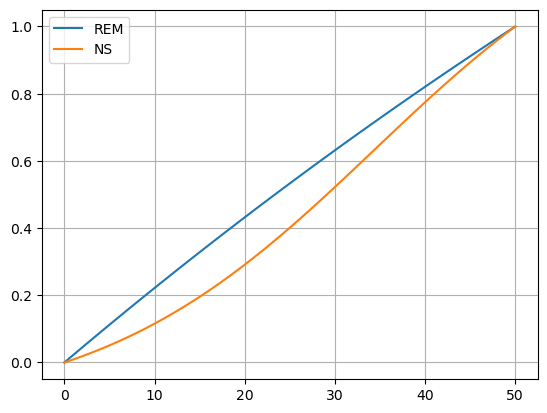

In [81]:
x=np.arange(0,51,1)
plt.plot(x, sigmoid_opt1(x/50.0, *params_REMfit), label='REM')
plt.plot(x, sigmoid_opt1(x/50.0, *params_NSfit), label='NS')
plt.legend()
plt.grid()
plt.show()

In [100]:
def countTrees(RFdic, events, ntrees=50):
    if(isinstance(events, np.ndarray)==False):
        events = np.asarray(events).reshape(1,-1)
    predictions=np.zeros(shape=(ntrees,len(events)))
    for i in range(0,ntrees):
        predictions[i] = RFdic['forest'].model.estimators_[i].predict(events)

    ntreessay = np.zeros(shape=(len(events),3))
    for i in range(0,len(events)):
        ntreessay[i] = [list(predictions[:,i]).count(0),list(predictions[:,i]).count(1),list(predictions[:,i]).count(2)]
    return ntreessay

In [101]:
countTrees(EOSdic['SLy'], [1.4, 90, -0.3, 0.2, 20])

array([[24., 17.,  9.]])

There is no probability inversion here. How to check in general?

Given a nns, there is a maximum nrem such that there is no probability inversion. So in theory it could happen. Does it?

-----LABEL 2 =  HAS REM-----


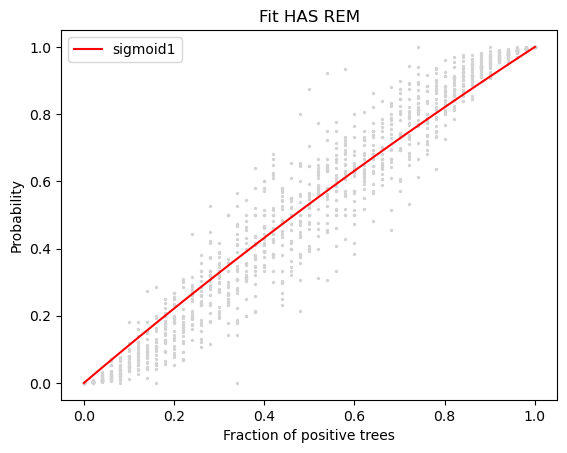

-----LABEL 1 AND 2 = HAS NS-----


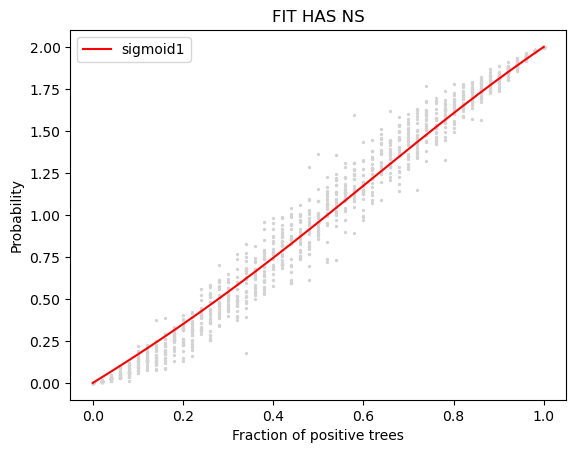

-----PLOTTED TOGETHER-----


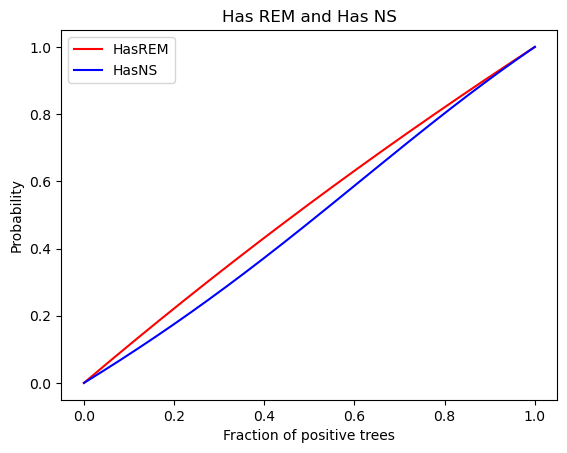

In [18]:
print("-----LABEL 2 =  HAS REM-----")
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_2'], s=2, c='lightgray')
#plt.scatter(EOSdic['SLy']['treesSaySo'], prob_2, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_2, b_2), c='red', label='sigmoid1')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Fit HAS REM')
plt.legend()
plt.show()

print("-----LABEL 1 AND 2 = HAS NS-----")
for eos in EOS:
    plt.scatter(EOSdic[eos]['treesSaySo'], EOSdic[eos]['BayesianProb_1']+EOSdic[eos]['BayesianProb_2'], s=2, c='lightgray')
#plt.scatter(EOSdic['SLy']['treesSaySo'], prob_1, s=2, c='black')
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_1, b_1)+sigmoid_opt1(np.linspace(0,1,200), a_2, b_2), c='red', label='sigmoid1')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('FIT HAS NS')
plt.legend()
plt.show()


print("-----PLOTTED TOGETHER-----")
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_2, b_2), c='red', label='HasREM')
plt.plot(np.linspace(0,1,200), sigmoid_opt1(np.linspace(0,1,200), a_1, b_1)+sigmoid_opt1(np.linspace(0,1,200), a_2, b_2), c='blue', label='HasNS')
plt.xlabel('Fraction of positive trees')
plt.ylabel('Probability')
plt.title('Has REM and Has NS')
plt.legend()
plt.show()
